# Wind Power Generation Analysis

This notebook integrates three key analyses on wind power generation data:

1. **Exploratory Data Analysis** (Statistical Relationships)
2. **Symbolic Regression** (PySR)
3. **Time Series Forecasting** (LSTM)

Each section builds on the same dataset to provide a comprehensive workflow from raw data to advanced modeling.

---


## 1. Setup and Data Loading

Import necessary libraries and load the data.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

# Path to the data file (adjust if necessary)
DATA_PATH = 'Wind_data/Location1.csv'

data = pd.read_csv(DATA_PATH)

# Parse timestamp column if present
if 'Time' in data.columns:
    data['Time'] = pd.to_datetime(data['Time'])
    data.set_index('Time', inplace=True)

# Preview
data.head()

,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power
Time,,,,,,,,,
2017-01-02 00:00:00,28.5,85,24.5,1.44,1.26,146,162,1.4,0.1635
2017-01-02 01:00:00,28.4,86,24.7,2.06,3.99,151,158,4.4,0.1424
2017-01-02 02:00:00,26.8,91,24.5,1.30,2.78,148,150,3.2,0.1214
2017-01-02 03:00:00,27.4,88,24.3,1.30,2.69,58,105,1.6,0.1003
2017-01-02 04:00:00,27.3,88,24.1,2.47,4.43,58,84,4.0,0.0793


## 2. Data Preprocessing

- Handle missing values
- Create sine/cosine wind direction features for modeling
- Inspect basic statistics


In [11]:
# %%
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler

# Drop any rows with missing features or target
target = 'Power'
features = [
    'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
    'windspeed_100m', 'windgusts_10m', 'winddirection_100m'
]

data = data.dropna(subset=features + [target])

# Create circular features for wind direction
data['sin_winddir_100m'] = np.sin(np.radians(data['winddirection_100m']))
data['cos_winddir_100m'] = np.cos(np.radians(data['winddirection_100m']))
# 1) create explicit v^3 feature
data['windspeed_100m_cubed'] = data['windspeed_100m'] ** 3

# 2) include it in your feature set
feature_cols = features + ['sin_winddir_100m', 'cos_winddir_100m', 'windspeed_100m_cubed']

# Remove outliers using z-score threshold of 3
cols_to_check = features + ['sin_winddir_100m', 'cos_winddir_100m', 'windspeed_100m_cubed', target]
z_scores = np.abs(data[cols_to_check].apply(zscore))
data = data[(z_scores < 3).all(axis=1)]

# Scale features to zero-mean, unit-variance
scaler = StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(data[feature_cols]),
    index=data.index,
    columns=feature_cols
)
# Replace original features with scaled values
for col in feature_cols:
    data[col] = data_scaled[col]

# Inspect basic statistics
data[feature_cols + [target]].describe()


,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_100m,windgusts_10m,winddirection_100m,sin_winddir_100m,cos_winddir_100m,windspeed_100m_cubed,Power
count,4.286500e+04,4.286500e+04,4.286500e+04,4.286500e+04,4.286500e+04,4.286500e+04,4.286500e+04,4.286500e+04,4.286500e+04,42865.000000
mean,-4.508751e-17,1.830023e-16,-5.039193e-17,1.153710e-16,-1.747141e-16,-1.113927e-16,-5.834855e-17,1.856545e-17,-2.652207e-17,0.396914
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,0.283753
min,-2.966051e+00,-2.997487e+00,-2.906232e+00,-2.430133e+00,-2.156352e+00,-2.062915e+00,-1.099872e+00,-1.422945e+00,-9.448698e-01,0.000000
25%,-8.130469e-01,-7.371286e-01,-7.665993e-01,-7.249765e-01,-7.818035e-01,-7.514359e-01,-9.302279e-01,-9.565547e-01,-7.229806e-01,0.146200
50%,-2.361221e-02,9.563509e-02,-2.145365e-02,-4.372023e-02,-1.403476e-01,2.245488e-01,-3.309756e-01,-8.414207e-02,-3.485692e-01,0.337700
75%,8.529679e-01,8.094325e-01,8.620761e-01,6.899404e-01,6.843813e-01,7.735401e-01,9.157192e-01,9.864130e-01,3.722493e-01,0.640600
max,2.365197e+00,1.642196e+00,2.001084e+00,2.524092e+00,3.311296e+00,1.597027e+00,1.798735e+00,1.510311e+00,4.253790e+00,0.989300


## 3. Exploratory Data Analysis

### 3.1 Pearson Correlation Matrix

Compute correlations between features and target, and visualize with a heatmap.


Pearson Correlation Matrix:
                      temperature_2m  relativehumidity_2m  dewpoint_2m  \
temperature_2m              1.000000            -0.142246     0.935455   
relativehumidity_2m        -0.142246             1.000000     0.211770   
dewpoint_2m                 0.935455             0.211770     1.000000   
windspeed_100m             -0.174966            -0.041399    -0.182685   
windgusts_10m               0.002480            -0.360185    -0.122099   
winddirection_100m         -0.152826            -0.080073    -0.178370   
sin_winddir_100m            0.125671             0.099847     0.158029   
cos_winddir_100m           -0.149184             0.005895    -0.145434   
windspeed_100m_cubed       -0.147006            -0.072393    -0.166896   
Power                      -0.208719            -0.064525    -0.223682   

                      windspeed_100m  windgusts_10m  winddirection_100m  \
temperature_2m             -0.174966       0.002480           -0.152826   
relativ

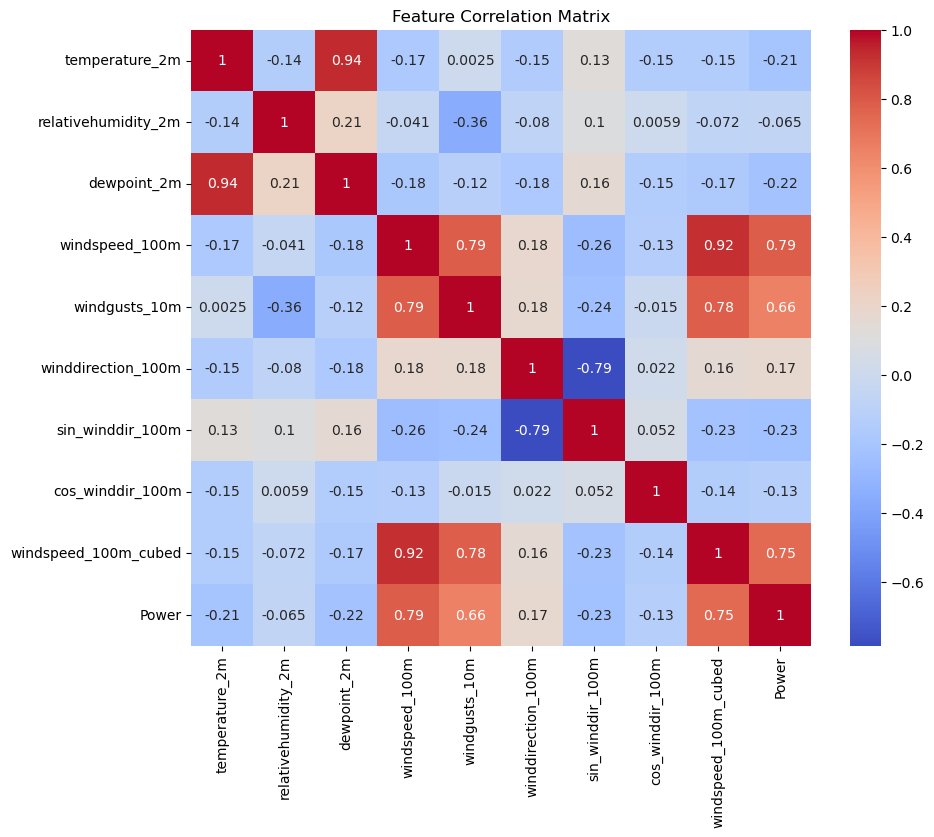

In [ ]:
all_cols = features + ['sin_winddir_100m', 'cos_winddir_100m', 'windspeed_100m_cubed', target]
corr = data[all_cols].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

## 4. Symbolic Regression using PySR

Discover interpretable equations relating features to power output.


In [ ]:
from sklearn.model_selection import train_test_split
from pysr import PySRRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Select recent subset for modeling
model_data = data.tail(24 * 30 * 3).copy() # Last 12 weeks of data
# Use pre-scaled features and raw target
X = model_data[feature_cols].values
# Target as a 1D array
y = model_data[target].values

# Chronological split: first 80 % = train, last 20 % = test
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

feature_names = feature_cols  # This will map x1, x2, x3, etc., to the actual feature names

model = PySRRegressor(
    niterations=100,
    binary_operators=['+', '-', '*', '/'],  # Add 'pow' for exponentiation
    unary_operators=['sin', 'cos', 'cube'],  # Add sine, cosine, etc.
    extra_sympy_mappings={
        'cube': lambda x: x**3,
    },
    loss='loss(x, y) = (x - y)^2',
    populations=50,
    verbosity=0
)
model.fit(X_train, y_train)

# Display discovered equations
print(model.equations_)
# Map feature names manually
best_equation = model.get_best()
print("\nBest equation found (with feature names):")
for i, feature in enumerate(feature_cols):
    best_equation = best_equation.replace(f"x{i}", feature)
print(best_equation)

# Evaluate on the test set
y_pred = model.predict(X_test)

rmse_sr = mean_squared_error(y_test, y_pred, squared=False)
mae_sr = mean_absolute_error(y_test, y_pred)
print(f"Symbolic Regression RMSE: {rmse_sr:.4f}, MAE: {mae_sr:.4f}")

# Create a DataFrame for the test set to include the index
test_data = model_data.iloc[split_idx:].copy()  # Use the last 20% as the test set
test_data['Actual Power'] = y_test
test_data['Predicted Power'] = y_pred



    complexity      loss                                           equation  \
0            1  0.101235                                         0.44089615   
1            5  0.029792                         (x3 * 0.266422) + 0.395139   
2            6  0.026763                  sin((x8 * 0.421503) + 0.46459866)   
3            7  0.025105            cube((sin(x3) * 0.2569906) + 0.6905402)   
4            8  0.024525          sin(cos(sin(x8 * 0.5481075) - 1.0405129))   
5            9  0.024466  sin(sin(x8 * 0.5447221) + 0.6958734) + -0.1624471   
6           10  0.024371  sin(sin(2.2882907 - sin((x8 - 0.5554779) * 0.6...   
7           11  0.024337  sin(sin(sin(sin((x8 + -0.28976515) * 0.6145621...   
8           12  0.023813  sin(sin(sin(((x2 * 0.07167269) + 0.5453287) * ...   
9           13  0.023753  sin(sin(sin(sin(x8 * ((x2 * 0.08040386) + 0.56...   
10          14  0.023383  sin(cos(sin((x8 * 0.48085794) + ((x4 - x0) * 0...   
11          15  0.023142  sin(cos(sin((x8 * 0.476635

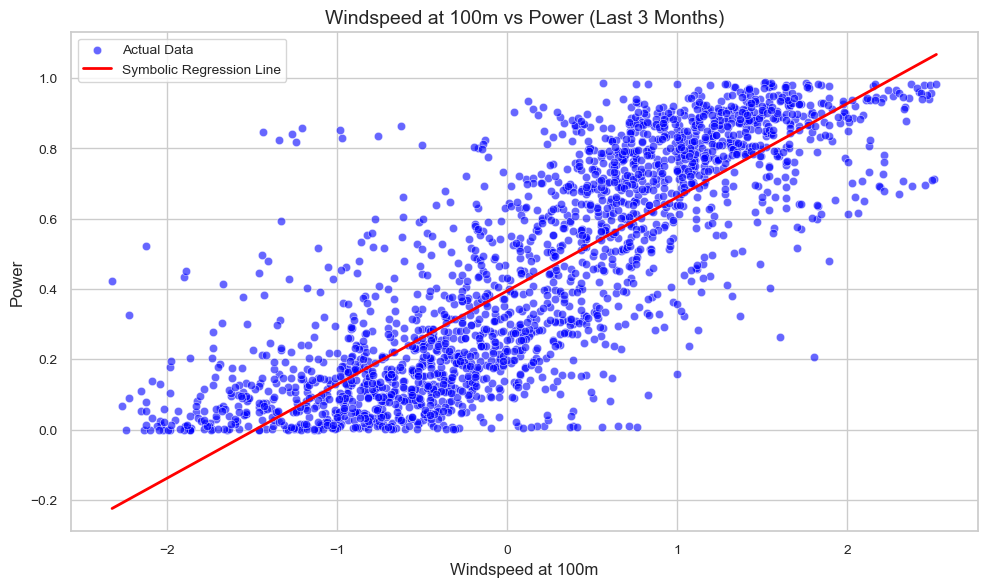

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the last three months of data
last_three_months_data = data.tail(24 * 30 * 3)

# Extract the windspeed at 100m and power values
windspeed = last_three_months_data['windspeed_100m']
power = last_three_months_data['Power']

# Generate predictions using the symbolic regression model
predicted_power = model.predict(last_three_months_data[feature_cols].values)

# Create the scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=windspeed, y=power, label='Actual Data', color='blue', alpha=0.6)

# Sort windspeed for a smooth regression line
sorted_indices = np.argsort(windspeed)
sorted_windspeed = windspeed.iloc[sorted_indices]
sorted_predicted_power = predicted_power[sorted_indices]

# Plot the regression line
plt.plot(sorted_windspeed, sorted_predicted_power, label='Symbolic Regression Line', color='red', linewidth=2)

# Add labels and title
plt.title('Windspeed at 100m vs Power (Last 3 Months)', fontsize=14)
plt.xlabel('Windspeed at 100m', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

Cubic Relationship: Power = 0.0882 * Windspeed^3
RMSE of the cubic fit: 0.4897
MAE of the cubic fit: 0.4247


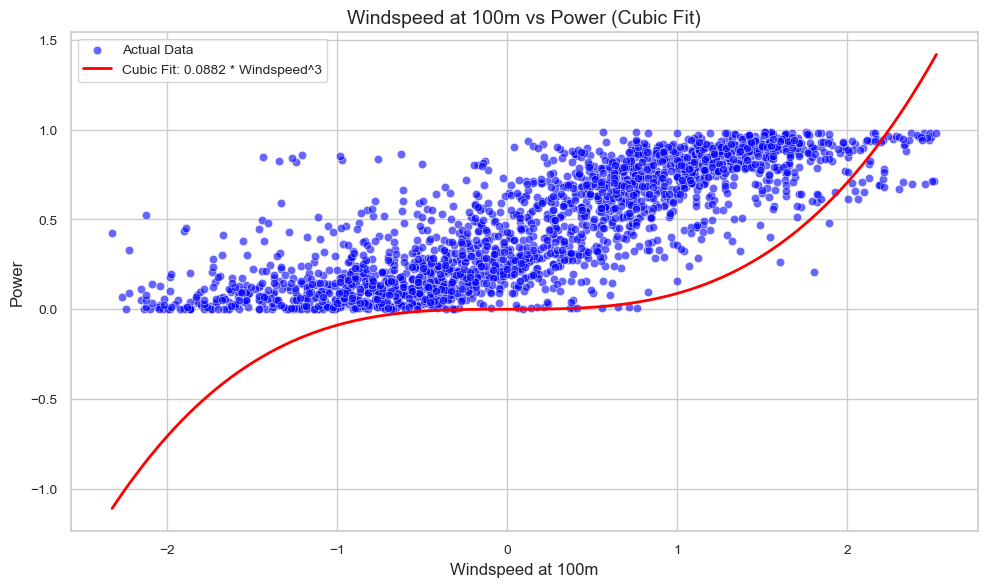

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Filter the last three months of data
last_three_months_data = data.tail(24 * 30 * 3)

# Extract the windspeed at 100m and power values
windspeed = last_three_months_data['windspeed_100m']
power = last_three_months_data['Power']

# Fit the cubic relationship: Power = A * Windspeed^3
A = np.sum(power * windspeed**3) / np.sum(windspeed**6)

# Print the cubic relationship
print(f"Cubic Relationship: Power = {A:.4f} * Windspeed^3")

# Generate predictions using the cubic relationship
predicted_power = A * windspeed**3

# Calculate RMSE and MAE
rmse = mean_squared_error(power, predicted_power, squared=False)
mae = mean_absolute_error(power, predicted_power)

# Print RMSE and MAE
print(f"RMSE of the cubic fit: {rmse:.4f}")
print(f"MAE of the cubic fit: {mae:.4f}")

# Plot the data and the cubic relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x=windspeed, y=power, label='Actual Data', color='blue', alpha=0.6)

# Sort windspeed for a smooth cubic fit line
sorted_indices = np.argsort(windspeed)
sorted_windspeed = windspeed.iloc[sorted_indices]
sorted_predicted_power = predicted_power.iloc[sorted_indices]

# Plot the cubic fit line
plt.plot(sorted_windspeed, sorted_predicted_power, label=f'Cubic Fit: {A:.4f} * Windspeed^3', color='red', linewidth=2)

# Add labels and title
plt.title('Windspeed at 100m vs Power (Cubic Fit)', fontsize=14)
plt.xlabel('Windspeed at 100m', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

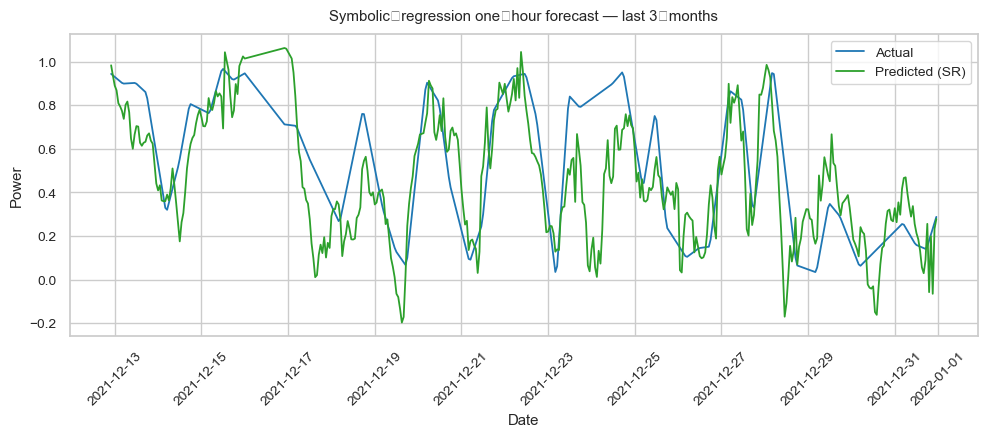

In [ ]:
# ----------------------------------------------------------
# Pretty plot: Symbolic regression vs. actual (last 3 months)
# ----------------------------------------------------------


# Build a clean frame for the 20 % chronological hold‑out
time_axis = model_data.index[split_idx:]        # aligns with y_test & y_pred
plot_df   = pd.DataFrame({
    "Time":      time_axis,
    "Actual":    y_test,
    "Predicted": y_pred
})

sns.set_theme(style="whitegrid", font_scale=0.9)
plt.figure(figsize=(10, 4.5))
sns.lineplot(data=plot_df, x="Time", y="Actual",
             label="Actual",   color="tab:blue",  linewidth=1.3)
sns.lineplot(data=plot_df, x="Time", y="Predicted",
             label="Predicted (SR)", color="tab:green", linewidth=1.3)

plt.title("Symbolic‑regression one‑hour forecast — last 3 months", pad=10)
plt.xlabel("Date"); plt.ylabel("Power")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("sr_test_predictions.png", dpi=300)
plt.show()

### 4.1 Run the symbollic regression on the symbollic predictions

Discovered equations (updated model):
    complexity      loss                                           equation  \
0            1  0.102492                                         0.43568182   
1            2  0.032091                                            sin(x9)   
2            3  0.029742                                   x9 - 0.010131316   
3            5  0.026964                          cube(cos(1.1737398 - x9))   
4            6  0.025688                   sin(sin(cube(x9 - -0.30138832)))   
5            7  0.024948              sin(cube(cube(cos(x9 - 0.88001984))))   
6            8  0.024651       sin(sin(0.52804685 - sin(x8 * -0.55857044)))   
7            9  0.024608    sin(sin(0.5304832 - sin(sin(x8 * -0.5819773))))   
8           10  0.024537  sin(sin(sin((x8 + -0.47162297) * 0.6105567) - ...   
9           11  0.024505  sin(sin(0.6619719 - sin(sin((x8 + -0.23516487)...   
10          12  0.024096  sin(sin(0.53105 - sin(x8 * ((x2 * -0.068522714...   
11          13

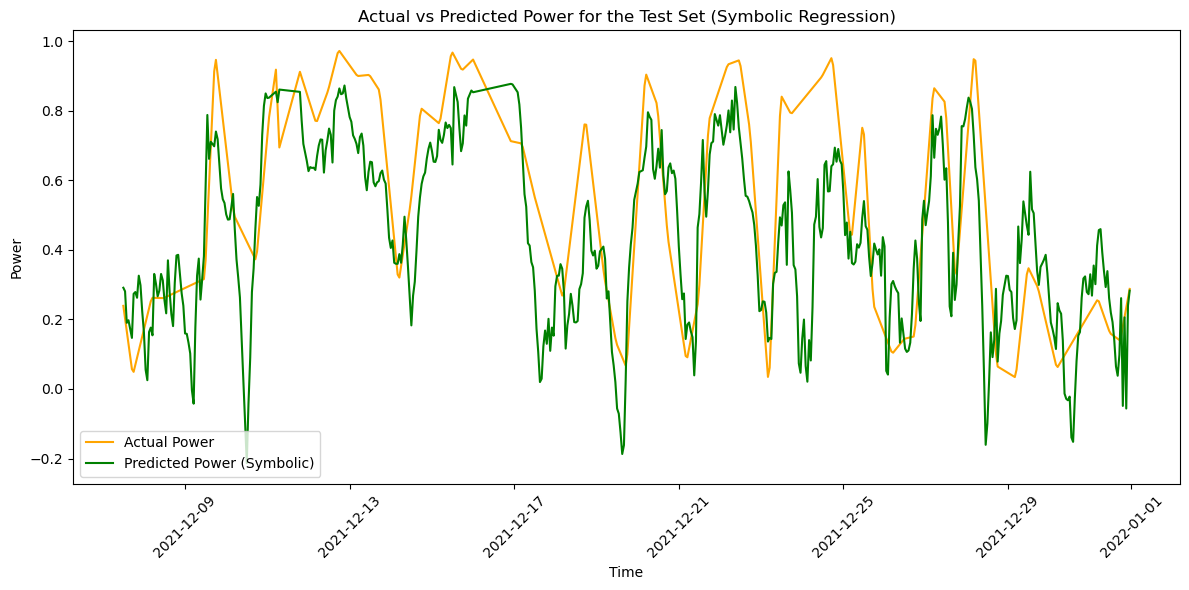

In [8]:
# Filter the last three months of data (assuming hourly data, 24 * 30 * 3 = 2160 hours)
last_three_months_data = data.tail(24 * 30 * 3)

# Generate predictions for the entire dataset using the initial symbolic regression model
last_three_months_data['symbolic_predictions'] = model.predict(last_three_months_data[feature_cols].values)


# Update feature columns to include the symbolic predictions
updated_feature_cols = feature_cols + ['symbolic_predictions']

# Use the updated feature set for the last three months
X_updated = last_three_months_data[updated_feature_cols].values
y_updated = last_three_months_data[target].values

# Chronological split: first 80 % = train, last 20 % = test
split_idx = int(len(X) * 0.8)
X_train_updated, X_test_updated = X_updated[:split_idx], X_updated[split_idx:]
y_train_updated, y_test_updated = y_updated[:split_idx], y_updated[split_idx:]

# Train a new symbolic regression model
model_updated = PySRRegressor(
    niterations=100,
    binary_operators=['+', '-', '*', '/'],
    unary_operators=['sin', 'cos', 'cube'],
    extra_sympy_mappings={'cube': lambda x: x**3},
    loss='loss(x, y) = (x - y)^2',
    populations=50,
    verbosity=0
)
model_updated.fit(X_train_updated, y_train_updated)

# Display discovered equations
print("Discovered equations (updated model):")
print(model_updated.equations_)

# Map feature names manually
best_equation_updated = model_updated.get_best()
print("\nBest equation found (with feature names):")
for i, feature in enumerate(updated_feature_cols):
    best_equation_updated = best_equation_updated.replace(f"x{i}", feature)
print(best_equation_updated)

# Evaluate the updated model on the test set
y_pred_updated = model_updated.predict(X_test_updated)

rmse_updated = mean_squared_error(y_test_updated, y_pred_updated, squared=False)
mae_updated = mean_absolute_error(y_test_updated, y_pred_updated)
print(f"\nUpdated Symbolic Regression RMSE: {rmse_updated:.4f}, MAE: {mae_updated:.4f}")

# Create a DataFrame for the test set to include the index
test_data = last_three_months_data.iloc[split_idx:].copy()  # Use the last 20% as the test set
test_data['Actual Power'] = y_test_updated
test_data['Predicted Power'] = y_pred_updated

# Plot actual vs predicted power for the test set
plt.figure(figsize=(12, 6))
sns.lineplot(data=test_data, x=test_data.index, y='Actual Power', label='Actual Power', color='orange')
sns.lineplot(data=test_data, x=test_data.index, y='Predicted Power', label='Predicted Power (Symbolic)', color='green')
plt.title('Actual vs Predicted Power for the Test Set (Symbolic Regression)')
plt.xlabel('Time')
plt.ylabel('Power')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
sns.set_theme(style="whitegrid", font_scale=0.9)
plt.figure(figsize=(10, 4.5))
sns.lineplot(data=plot_df, x="Time", y="Actual",
             label="Actual",   color="tab:blue",  linewidth=1.3)
sns.lineplot(data=plot_df, x="Time", y="Predicted",
             label="Predicted (SR)", color="tab:green", linewidth=1.3)

plt.title("Symbolic‑regression one‑hour forecast — last 3 months", pad=10)
plt.xlabel("Date"); plt.ylabel("Power")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("sr_test_predictions.png", dpi=300)
plt.show()

## 5. LSTM Time Series Forecasting

Use an LSTM network to forecast future wind power from historical power values.


In [21]:


# Prepare univariate series (raw Power values)
ts = data[[target]].tail(24 * 30 * 3).values  # shape (n_samples, 1)

def create_seq(dataset, look_back=52):
    Xs, ys = [], []
    for i in range(look_back, len(dataset)):
        Xs.append(dataset[i - look_back:i, 0])
        ys.append(dataset[i, 0])
    return np.array(Xs), np.array(ys)

look_back = 52
train_size = int(len(ts) * 0.8)

# Split raw series into train and test slices for sequence creation
ts_train = ts[:train_size]
ts_test = ts[train_size - look_back:]

X_train_ts, y_train_ts = create_seq(ts_train, look_back)
X_test_ts, y_test_ts = create_seq(ts_test, look_back)

# Reshape for LSTM: [samples, timesteps, features]
X_train_ts = X_train_ts.reshape(-1, look_back, 1)
X_test_ts = X_test_ts.reshape(-1, look_back, 1)

# Build and train LSTM model
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(look_back, 1)),
    LSTM(64, return_sequences=False),
    Dense(25),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_model.fit(
    X_train_ts, y_train_ts,
    epochs=5, batch_size=32,
    validation_data=(X_test_ts, y_test_ts),
    verbose=1
)

# Predict and evaluate
pred = lstm_model.predict(X_test_ts).flatten()
eval_rmse = mean_squared_error(y_test_ts, pred, squared=False)
eval_mae = mean_absolute_error(y_test_ts, pred)
print(f"LSTM RMSE: {eval_rmse:.4f}, MAE: {eval_mae:.4f}")



Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0858 - val_loss: 0.0161
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0136 - val_loss: 0.0088
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0072 - val_loss: 0.0052
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0029 - val_loss: 0.0028
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
LSTM RMSE: 0.0531, MAE: 0.0397


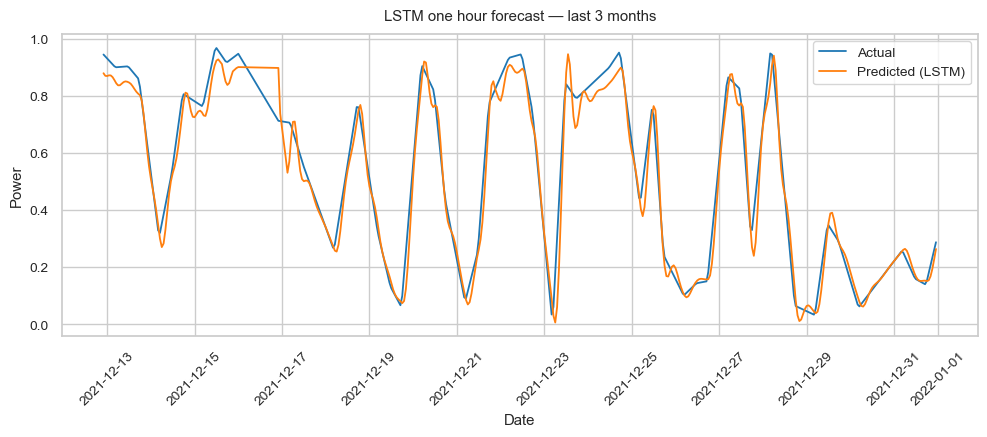

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

tail_df   = data.tail(24 * 30 * 3)          # last 3 months
time_axis = tail_df.index[train_size:]      # aligns with y_test_ts and pred

plot_df = pd.DataFrame({
    "Time":      time_axis,
    "Actual":    y_test_ts,
    "Predicted": pred
})

sns.set_theme(style="whitegrid", font_scale=0.9)
plt.figure(figsize=(10, 4.5))
sns.lineplot(data=plot_df, x="Time", y="Actual",
             label="Actual", color="tab:blue", linewidth=1.3)
sns.lineplot(data=plot_df, x="Time", y="Predicted",
             label="Predicted (LSTM)", color="tab:orange", linewidth=1.3)

plt.title("LSTM one hour forecast - test data", pad=10)

plt.xlabel("Date"); plt.ylabel("Power")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("lstm_test_predictions.png", dpi=300)
plt.show()

### How does the amount of training data impact the performance

In [ ]:
#LSTM

months      = [1, 3, 6, 12, 24]   # windows to test
look_back   = 52                  # unchanged sequence length
rmse_symb, mae_symb = [], []

for m in months:
    n_hours = 24 * 30 * m                 # crude '30‑day' month
    df      = data.tail(n_hours)          # keep last m months chronologically

    # ---------- prepare features & target ----------
    X = df[feature_cols].values
    y = df[target].values

    # chronological 80/20 split (no shuffle)
    split  = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # ---------- train new PySR model ----------
    sr = PySRRegressor(
        niterations      = 100,
        populations      = 50,
        binary_operators = ["+","-","*","/"],
        unary_operators  = ["sin","cos","cube"],
        extra_sympy_mappings={"cube": lambda x: x**3},
        loss             = "loss(x, y) = (x - y)^2",
        verbosity        = 0,
    )
    sr.fit(X_train, y_train)

    # ---------- evaluate ----------
    y_pred = sr.predict(X_test)
    rmse_symb.append(mean_squared_error(y_test, y_pred, squared=False))
    mae_symb.append(mean_absolute_error(y_test, y_pred))
    print(f"{m:>2} mo  →  RMSE {rmse_symb[-1]:.4f}  MAE {mae_symb[-1]:.4f}")

# --------------- plot RMSE & MAE ----------------
plt.figure(figsize=(6,4))
plt.plot(months, rmse_symb, marker='o', label='RMSE')
plt.plot(months, mae_symb,  marker='s', label='MAE')
plt.xticks(months)
plt.xlabel('Training window (months)')
plt.ylabel('Error (Power units)')
plt.title('Symbolic‑regression error vs. amount of training data')
plt.legend()
plt.tight_layout()
plt.show()

 1 mo → RMSE 0.1125  MAE 0.0976
 3 mo → RMSE 0.0501  MAE 0.0365
 6 mo → RMSE 0.0383  MAE 0.0253
12 mo → RMSE 0.0241  MAE 0.0144
24 mo → RMSE 0.0183  MAE 0.0106


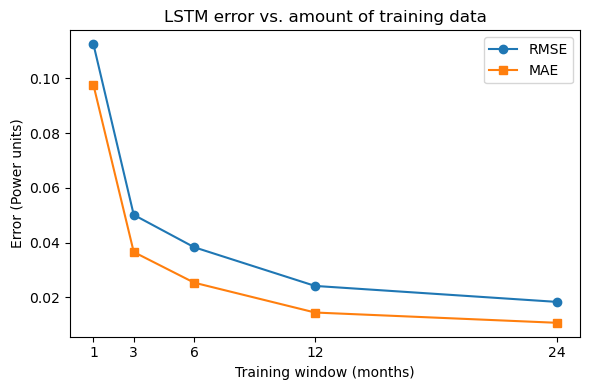

In [ ]:
# LSTM 


# PARAMETERS
look_back  = 52                # 52 h ≈ 2.2 d  sliding window
epochs     = 5
batch_size = 32
months     = [1, 3, 6, 12, 24] # windows to test
#
rmse_list, mae_list = [], []
# -------------------------------------------------------------
for m in months:
    n_hours = 24 * 30 * m           # crude "30‑day month"
    ts      = data[[target]].tail(n_hours).values

    # chronological split (80/20)
    split    = int(len(ts) * 0.8)
    ts_train = ts[:split]
    ts_test  = ts[split - look_back:]

    X_train, y_train = create_seq(ts_train, look_back)
    X_test,  y_test  = create_seq(ts_test,  look_back)
    X_train = X_train.reshape(-1, look_back, 1)
    X_test  = X_test.reshape(-1, look_back, 1)

    # fresh model for each window
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(look_back, 1)),
        LSTM(64),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs,
              batch_size=batch_size, verbose=0)

    pred   = model.predict(X_test, verbose=0).flatten()
    rmse   = mean_squared_error(y_test, pred, squared=False)
    mae    = mean_absolute_error(y_test, pred)
    rmse_list.append(rmse)
    mae_list.append(mae)
    print(f'{m:>2} mo → RMSE {rmse:.4f}  MAE {mae:.4f}')

# ----------------- PLOT --------------------------------------
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(months, rmse_list, marker='o',  label='RMSE')
plt.plot(months, mae_list,  marker='s',  label='MAE')
plt.xticks(months)
plt.xlabel('Training window (months)')
plt.ylabel('Error (Power units)')
plt.title('LSTM error vs. amount of training data')
plt.legend()
plt.tight_layout()
plt.show()